# Autoregressive Quantum Neural Networks in PennyLane

### By Jon Pilarte

## Introduction📘

In classical Machine Learning (ML)🧠, autoregressive models can predict each value based on previous values, which is particularly useful in tasks like Time Series Forecasting📈 and Natural Language Processing (NLP)💬. This concept can be extended to Quantum Neural Networks (QNNs), where each qubit’s state is conditioned on the states of previous qubits, capturing dependencies within a quantum system🌀.

The mathematical formula for a general autoregressive model can be represented as:

$$
x_t = f(x_{t-1}, x_{t-2}, \ldots, x_1) + \epsilon
$$

where  $x_t$ is the current value, $x_{t-1}, x_{t-2}, \ldots, x_1$ are the previous values, and $\epsilon$ is a noise term. In the quantum context, we use controlled quantum gates🎛️ to model these dependencies, where each qubit’s state is determined by the states of previous qubits.

In this tutorial, we will:
- ⚙️ Build an Autoregressive QNN where each qubit rotation is conditioned on the previous qubits’ states
- 🧮 Apply this QNN within a Variational Monte Carlo (VMC) framework to find the ground state energy of a Hamiltonian

---

## Autoregressive QNN Fundamentals⚛️

### Quantum Circuit Construction

In order to construct an Autoregressive QNN, we make use of Controlled Rotation Gates🔄 that condition each qubit’s rotation on the previous qubits states. Each qubit $q_i$ is rotated based on an angle $\theta_i$, but only if all previous qubits are in a specified state. For example, the gate might only operate if all the previous qubits are in the `|1⟩` state (or another specified state).

The operation of a Controlled Rotation Gate $CR_y(\theta)$ can be represented as:

$$
CR_y(\theta) = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & \cos(\theta/2) & -\sin(\theta/2) \\
0 & 0 & \sin(\theta/2) & \cos(\theta/2) \\
\end{bmatrix}
$$

Each gate $CR_y(\theta)$🔄 operates on qubits $i$ and $i+1$, creating dependencies between them🔗. Let’s implement a QNN where the state of each qubit depends on the previous one.

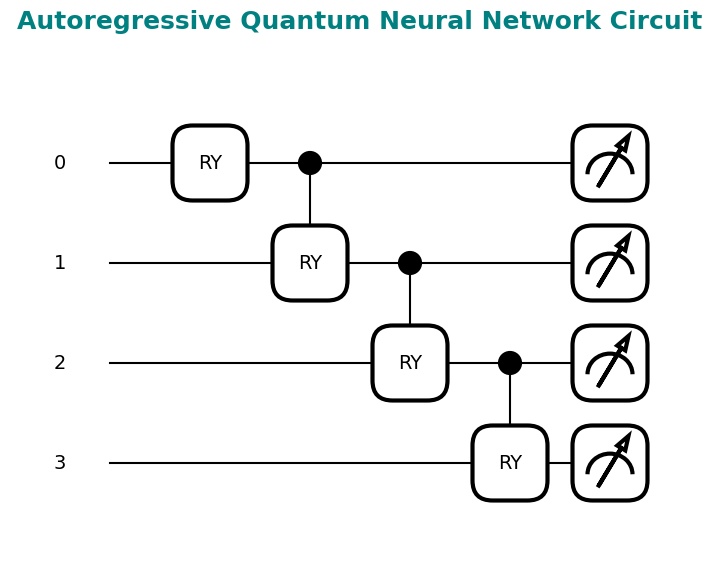

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Set up a 4-qubit device
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def autoregressive_qnn(inputs):
    # Initialize the first qubit based on the input angle
    qml.RY(inputs[0], wires=0)

    # Apply controlled rotations for each subsequent qubit
    for i in range(1, 4):
        qml.CRY(inputs[i], wires=[i-1, i])

    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

# Provide values for inputs and show the quantum circuit
inputs = [3 * np.pi / 4, np.pi, 5 * np.pi / 6, 3 * np.pi / 2]


qml.draw_mpl(autoregressive_qnn)(inputs)
plt.title("Autoregressive Quantum Neural Network Circuit", fontsize=18, fontweight='bold' ,color='teal', pad=25)
plt.show()

In [2]:
autoregressive_qnn([3 * np.pi / 4, np.pi, 5 * np.pi / 6, 3 * np.pi / 2])

[-0.7071067811865476,
 -0.7071067811865476,
 -0.5927523103333904,
 0.20362384483330487]

---

## Application: Variational Monte Carlo (VMC) with QNN🎲💻

### Defining the Local Energy and Cost Function

In Variational Monte Carlo🧮, we try to find the ground state of a Hamiltonian $H$⚛️ by minimizing the expectation value of the energy:

$$
E = \langle \psi | H | \psi \rangle
$$

The Hamiltonian $H$ can be represented as a matrix🔢 and in this example, we’ll use a 4-qubit system with the Hamiltonian:

$$
H = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

The local energy⚡ for a given input state $|\psi\rangle$ is then:

$$
E_{\text{local}} = \frac{\langle \psi | H | \psi \rangle}{\langle \psi | \psi \rangle}
$$

Now we can define the local energy function using this Hamiltonian.

In [3]:
# Define a simple Hamiltonian for demonstration
H = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

def local_energy(inputs):
    state = autoregressive_qnn(inputs)
    
    # Compute the numerator
    numerator = np.dot(state, np.dot(H, state))

    # Compute the denominator (normalization term)
    denominator = np.dot(state, state)
    
    # Return the normalized local energy
    return numerator / denominator

print(local_energy([3 * np.pi / 4, np.pi, 5 * np.pi / 6, 3 * np.pi / 2]))

-0.22249327445642425


In this section, explicitly prove the algebraic operations involved in calculating the local energy🔋 for the first iteration. After this, the weights in the Autoregressive QNN⚛️ will be adjusted to minimize this local energy (the cost function🎯). Starting from the initial QNN output state vector: 
$$ 
\psi = [-0.7071, -0.7071, -0.5928, 0.2036] 
$$

<div style="font-size: 100%; line-height: 1.4;">

##### 🔹 Calculate $ H \psi $:

$$
H \cdot \psi = \begin{bmatrix} 
1 & 0 & 0 & 0 \\ 
0 & -1 & 0 & 0 \\ 
0 & 0 & -1 & 0 \\ 
0 & 0 & 0 & 1 
\end{bmatrix} 
\begin{bmatrix} 
-0.7071 \\ 
-0.7071 \\ 
-0.5928 \\ 
0.2036 
\end{bmatrix}
= 
\begin{bmatrix} 
-0.7071 \\ 
0.7071 \\ 
0.5928 \\ 
0.2036 
\end{bmatrix}
$$

##### 🔹 Compute $ \langle \psi | H | \psi \rangle = \psi^T \cdot (H \cdot \psi) $:

$$
\langle \psi | H | \psi \rangle = 
\begin{bmatrix} 
-0.7071 & -0.7071 & -0.5928 & 0.2036 
\end{bmatrix} 
\cdot 
\begin{bmatrix} 
-0.7071 \\ 
0.7071 \\ 
0.5928 \\ 
0.2036 
\end{bmatrix}
$$

$$
= (-0.7071 \times -0.7071) + (-0.7071 \times 0.7071) + (-0.5928 \times 0.5928) + (0.2036 \times 0.2036)
$$
$$
= 0.5 - 0.5 - 0.3514 + 0.0415 = -0.309
$$

##### 🔹 Calculate the Normalization Term $ \langle \psi | \psi \rangle $:

$$
\langle \psi | \psi \rangle = 
\begin{bmatrix} 
-0.7071 & -0.7071 & -0.5928 & 0.2036 
\end{bmatrix} 
\cdot 
\begin{bmatrix} 
-0.7071 \\ 
-0.7071 \\ 
-0.5928 \\ 
0.2036 
\end{bmatrix}
$$

$$
= (-0.7071)^2 + (-0.7071)^2 + (-0.5928)^2 + (0.2036)^2
$$
$$
= 0.5 + 0.5 + 0.3514 + 0.0415 = 1.3929
$$

##### 🔹 Compute the Normalized Local Energy:

$$
E_{\text{local}} = \frac{\langle \psi | H | \psi \rangle}{\langle \psi | \psi \rangle} = \frac{-0.309}{1.3929} \approx -0.222
$$
<br>
</div>

<p align="center">
    <img src="QMC.png" alt="Description of Image" width="57%">
</p>

---

## Optimization and Training🔺↘️
### Gradient Descent on the QNN Parameters in PennyLane

To find the ground state energy⚛️, we use PennyLane's `qml.GradientDescentOptimizer` to adjust the QNN parameters $\theta$ and minimize the cost function, defined as the **local energy**🔋 of the system.

With `qml.GradientDescentOptimizer(stepsize=0.1)`, we iteratively update $\theta$ to reduce $E_{\text{local}}(\theta)$ by following the negative gradient of the cost function. Each parameter $\theta_i$ is updated as:

$$
\theta_i \leftarrow \theta_i - \eta \frac{\partial E_{\text{local}}}{\partial \theta_i}
$$

where $\eta = 0.1$ is the step size set by `stepsize=0.1`. PennyLane calculates the gradient using the **parameter-shift rule**🔄, which evaluates $\frac{\partial E_{\text{local}}}{\partial \theta_i}$ by shifting each parameter:

$$
\frac{\partial E_{\text{local}}}{\partial \theta_i} \approx \frac{E_{\text{local}}(\theta_i + \frac{\pi}{2}) - E_{\text{local}}(\theta_i - \frac{\pi}{2})}{2}
$$

The optimizer performs this gradient descent process iteratively:

1. **Initialize**🛠️: Start with initial parameters $\theta$.
2. **Compute Cost and Gradient**🔺↘️: Evaluate $E_{\text{local}}(\theta)$ and its gradient.
3. **Update Parameters**🔧: Adjust $\theta$ based on the computed gradient.

This loop continues until convergence🌟, when either the change in $E_{\text{local}}(\theta)$ or the parameter values becomes very small, indicating a minimal energy has been found.

![Alt text](Gradient.jpg)

Step 0: cost = -0.22249327445642425
Step 10: cost = -0.3121963984980378
Step 20: cost = -0.32613898345620856
Step 30: cost = -0.3307797873889607
Step 40: cost = -0.33243053271910633
Step 50: cost = -0.33301505891570293
Step 60: cost = -0.3332212265409878
Step 70: cost = -0.3332938533738575
Optimized inputs: [2.45968476 3.14159265 3.13419792 4.5860999 ]


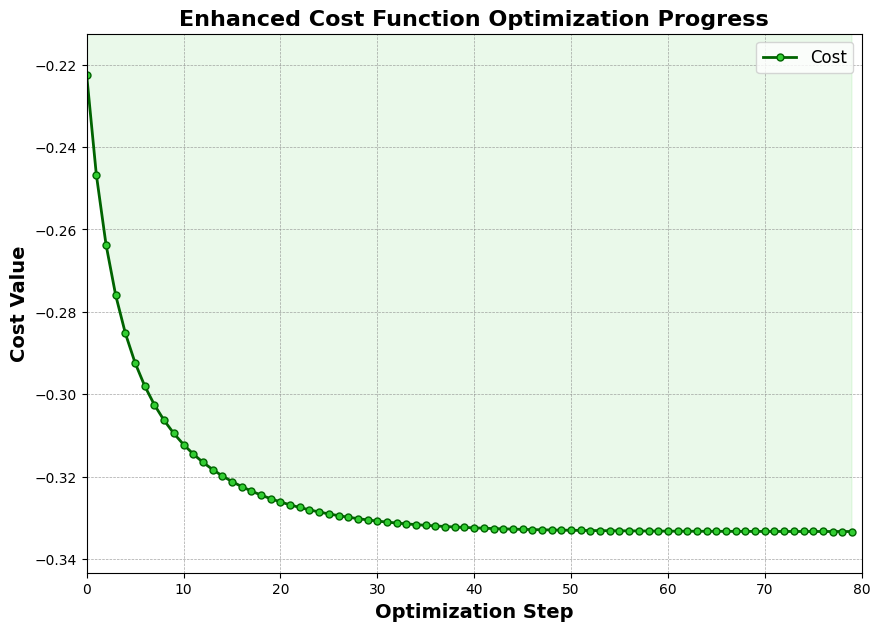

In [4]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 80  
inputs = np.array([3 * np.pi / 4, np.pi, 5 * np.pi / 6, 3 * np.pi / 2], requires_grad=True)
cost_values = []  # List to store cost values at each step

for i in range(steps):
    inputs, cost_val = opt.step_and_cost(local_energy, inputs)
    cost_values.append(cost_val)  # Record the cost value
    if i % 10 == 0:
        print(f"Step {i}: cost = {cost_val}")

print("Optimized inputs:", inputs)


# Plotting the cost over optimization steps
import matplotlib.pyplot as plt
steps = list(range(80))

plt.figure(figsize=(10, 7))
plt.plot(steps, cost_values, label='Cost', marker='o', markersize=5, linewidth=2, color='darkgreen', markerfacecolor='limegreen')
plt.fill_between(steps, cost_values, color='limegreen', alpha=0.1)
plt.xlabel('Optimization Step', fontsize=14, fontweight='bold')
plt.ylabel('Cost Value', fontsize=14, fontweight='bold')
plt.title('Enhanced Cost Function Optimization Progress', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.xlim(0, 80)
plt.ylim(min(cost_values) - 0.01, max(cost_values) + 0.01)
plt.legend(loc='upper right', fontsize=12)
plt.show()

After this process, the inputs should be tuned to provide the lowest possible energy estimate⏬ for the ground state of the Hamiltonian⚛️ based on our Variational Ansatz (the Autoregressive QNN🤖).

---

## Final Thoughts and Future Directions💡
This tutorial has covered how to construct an Autoregressive QNN🤖 within a Variational Monte Carlo (VMC) framework🧮 and how to find ground states of Hamiltonians. By using this autoregressive structure, the QNN efficiently samples quantum states and provides a powerful tool for quantum state estimation. The next steps for this project could be:

* **Implementing Symmetry Constraints**⚖️: Following Xanadu's recent research conducted in the 1st reference below, implement symmetry constraints that could improve computational efficiency.
* **Scaling to Larger Systems**🌌: One could challenge the QNN model to handle larger quantum systems and evaluate its performance on more complex Hamiltonians.
* **Exploring Optimization Techniques and Architectures**🏁: We could experiment alternative optimization methods and different QNN architectures.
* **Further Integrating with PennyLane**🛠️: PennyLane’s offers a flexible toolkit and the techniques in this tutorial can be extended to address more complex quantum simulations and Quantum Machine Learning tasks.

## References📖🌐
1. Mayshev, A., Arrazola, J. M., & Lvovsky, A. I. (2023). Autoregressive neural quantum states with quantum number symmetries. *arXiv preprint arXiv:2310.04166*.
2. "Variational Monte Carlo." *Wikipedia*, 2024. Accessed November 13, 2024. [https://en.wikipedia.org/wiki/Variational_Monte_Carlo](https://en.wikipedia.org/wiki/Variational_Monte_Carlo)
3. Dewee, H. (2024). "Gradient Descent: Introduction." *Medium*. [https://medium.com/@hosamedwee/gradient-descent-1-introduction-333b1134b023](https://medium.com/@hosamedwee/gradient-descent-1-introduction-333b1134b023)
4. "Quantum Monte Carlo on Quantum Computers." *Amazon Web Services Quantum Blog*. [https://aws.amazon.com/es/blogs/quantum-computing/quantum-monte-carlo-on-quantum-computers/](https://aws.amazon.com/es/blogs/quantum-computing/quantum-monte-carlo-on-quantum-computers/)